In [1]:
import numpy
import pandas, numpy, csv, re
from cStringIO import StringIO
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid", {'axes.grid' : False})
import matplotlib.patches as mpatches
from pyteomics import fasta
import collections
import scipy.stats as stats
import os
import subprocess

Note that I did two different DeMixQ processings.  
First, I did EICExtractor with 120 s RT tolerance:  
 But the estimation of feature missing values was only done for (12 out of 20) maps where the feature intensities correlated (r2 > 0.5) well with eic intensities  
 I changed the my_DeMixQ_data_processing to include those cases where the number of ic1x is less than ic0
 The RT-dependent median-shift feature intensity normalization was done for all runs (wheter or not the feature-eic pairs correlate or not)  
Then I ran EICExtractor again with 60 s tol.  
 Much better feature intensity - EIC intensity correlation.  
 See @rackham eicExtractor/consensusMap_rt_tol_60.csv  
 Then I ran the first part of the DeMixQ processing at rackham as usual and export the dx dataframe.  
 Read it from /home/vitalv/cyano_dataset_20170421/PTM/dx_eic_rt_tol_60.csv and finish my_DeMixQ_data processing with the median-shift RT normalization  
 AND export to '/home/vitalv/cyano_dataset_20170421/PTM/peptide_quant_ptm.csv'. That is the file I use here

Use or Not Diffacto for this PTM analysis.

Use it:    
	-I note in the abundance plots there are some peptides with quite high variability of abundance in one sample. Could Diffacto rid me of those (if they have low weight)
	-For proteins with several peptides: I can be more confident that the peptides with high weights are more reliably quantified. 

Not use it:  
	-I don't really need to get a summarized protein abundance value. I can just focus on phospho (or acetyl-) peptides
	-For proteins with just one peptide: Even if these proteins can't be quantified, (I just want to focus on the peptide), the peptide abundance might be "correct"

In [2]:
#peptide_quant = "/home/vitalv/cyano_dataset_20170421/PTM/peptide_quant.csv"
peptide_quant = '/home/vitalv/cyano_dataset_20170421/PTM/peptide_quant_ptm.csv'

num_samples = 5
num_replica = 4


In [3]:
peptides = pandas.read_csv(peptide_quant)

#Note it could be nice to find an MS/MS spectrum of this peptide with and without phosphorylation : TOPPView
samples = peptides.columns[1:] 

#All peptides are already filtered in the DeMixQ processing so that they are detected in at least one replicate in each of the samples/conditions
peptides["base_seq"] = peptides.peptide.str.replace('\(Phospho\)|\(Oxidation\)|\(Carbamidomethyl\)|\(Acetyl\)', '')

#get all phospho-peptides
phospho_peptides = peptides[peptides.peptide.str.contains("Phosph")]

#and all acetyl-peptides
acetyl_peptides = peptides[peptides.peptide.str.contains("Acetyl")]


In [4]:
#get list of proteins for the phosphopeptides 
db = "/home/vitalv/database/Synechocystis_PCC6803_protein_sequences.fasta"
phospho_pep_prot_dict = {}

for pep in phospho_peptides.base_seq:
	for header, seq, in fasta.read(db):
		if pep in seq:
			phospho_pep_prot_dict[pep] = header.split(" ")[0]
for ix, row in phospho_peptides.iterrows():
	pep = phospho_peptides.loc[ix, 'base_seq']
	phospho_peptides.loc[ix, 'protein'] = phospho_pep_prot_dict[pep]

#same thing for acetyl-peptides
acetyl_pep_prot_dict = {}
for pep in acetyl_peptides.base_seq:
	for header, seq, in fasta.read(db):
		if pep in seq:
			acetyl_pep_prot_dict[pep] = header.split(" ")[0]
for ix, row in acetyl_peptides.iterrows():
	pep = acetyl_peptides.loc[ix, 'base_seq']
	acetyl_peptides.loc[ix, 'protein'] = acetyl_pep_prot_dict[pep]

#and for all peptides
all_pep_prot_dict = {}
for pep in list(set(peptides.base_seq)):
	for header, seq, in fasta.read(db):
		if pep in seq:
			all_pep_prot_dict[pep] = header.split(" ")[0]


/home/vitalv/.local/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/vitalv/.local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
#Add the protein column to cons for the abundance plots
peptides["protein"] = pandas.Series()
for i, row in peptides.iterrows():
	p = peptides.ix[i].base_seq
	if p in all_pep_prot_dict.keys():
		peptides.loc[i, 'protein'] = all_pep_prot_dict[p]
	else:
		peptides.loc[i, 'protein'] = ""

In [6]:
#Frequency S / T / Y position of the phosphorylation
phospho_residues = []
a = list(phospho_peptides.peptide)
p = re.compile("\(Phospho\)")
for pep in a:
	for match in p.finditer(pep):
		phospho_residue_ix = match.start()-1
		phospho_residues += pep[phospho_residue_ix]
phospho_residue_frequency = collections.Counter(phospho_residues)
print "Number of phosphopeptides: %s"%len(set(phospho_peptides.peptide)) 
print "Number of phosphorylation sites: %s"% len(phospho_residues)
print "Number of phosphoproteins: %s"% len(set(phospho_peptides["protein"])) 
#NOTE! Number of phosphorylation sites/events might be larger than number of phospho-peptides if 1 phosphopeptide contains several phosphorylations


Number of phosphopeptides: 32
Number of phosphorylation sites: 36
Number of phosphoproteins: 31


In [7]:
#Frequency and residue-position of acetylation
acetyl_residues = []
ac = list(acetyl_peptides.peptide)
ar = re.compile("\(Acetyl\)")
for pep in ac:
	for match in ar.finditer(pep):
		acetyl_residue_ix = match.start()-1
		acetyl_residues += pep[acetyl_residue_ix]
acetyl_residue_frequency = collections.Counter(acetyl_residues)
print "Number of acetylpeptides: %s"%len(set(acetyl_peptides.peptide)) 
print "Number of acetylation sites: %s"% len(acetyl_residues)
print "Number of acetylproteins: %s"% len(set(acetyl_peptides["protein"])) 


Number of acetylpeptides: 27
Number of acetylation sites: 30
Number of acetylproteins: 26


In [8]:
#proteins having > 1 phosphopeptide 
multiphosphopep_proteins = []
#collections.Counter(phospho_peptides["protein"]) # ssr0692:2;  sll0726:2;  slr2058:2
for prot, num_phosphopep in collections.Counter(phospho_peptides["protein"]).iteritems():
	if num_phosphopep > 1:
		multiphosphopep_proteins.append(prot)
for p in multiphosphopep_proteins:
	print p
	print phospho_peptides[phospho_peptides["protein"] == p].peptide
	print "\n"


slr1241
2407    M(Oxidation)QIS(Phospho)PAFKYK
3846        Y(Phospho)KVSIDPGK(Acetyl)
Name: peptide, dtype: object




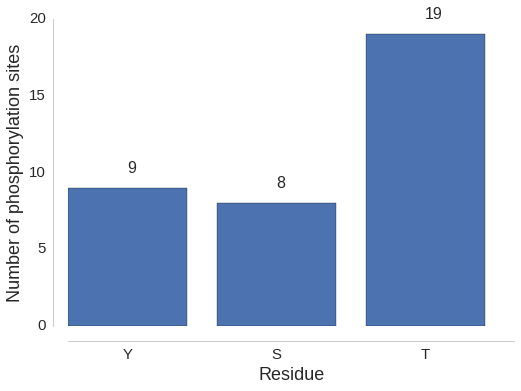

In [10]:
rects = plt.bar([1,2,3], phospho_residue_frequency.values())
bar_width = 0.8
bar_l = [i+1 for i in range(3)] # positions of the left bar-boundaries
tick_pos = [i+(bar_width/2) for i in bar_l] # positions of the x-axis ticks (center of the bars as bar labels)
plt.ylabel("Number of phosphorylation sites", fontsize=18)
plt.yticks(fontsize=19)
plt.xlabel("Residue", fontsize=18)
plt.title("", fontsize=18)
plt.xticks(tick_pos, phospho_residue_frequency.keys(), fontsize=20)
for t in range(len(tick_pos)): 
	plt.text(tick_pos[t], phospho_residue_frequency.values()[t]+1, phospho_residue_frequency.values()[t], fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(False) 
sb.despine(offset=15)#, trim=True)
sb.despine(top=True, right=True)
plt.show()



#### GET DIFFERENTIAL PHOSPHO and ACETYL- PEPTIDES

In [11]:
for i in numpy.array(samples).reshape(num_samples, num_replica):
	median = peptides[i].median(axis=1)
	avg = peptides[i].mean(axis=1)
	peptides[i[0].split("_")[3]+"_median"] = median
	peptides[i[0].split("_")[3]+"_mean"] = avg

means = [c for c in peptides.columns if "_mean" in c]
medians = [c for c in peptides.columns if "_median" in c]
data = peptides[["protein"]+ list(samples) + means + medians]

for index, row in data.iterrows():
	#Get pandas df for each prot with columns dependent_variable, factor_1 and factor_2:
	pep_df = pandas.DataFrame(columns=["dependent_variable", "group"])
	pep_df.group = [ s.split("_")[3] for s in samples ] #works only for cyano_dataset20170421 where samples are named "20170419_GM_Cyano_60_R4_BC4_01_2488"
	pep_df.dependent_variable = row[samples].values
	k = len(pandas.unique(pep_df.group))  # number of samples
	N = len(pep_df.values)  # samples times replica
	n = pep_df.groupby('group').size()[0] #num_replica
	DFbetween = k - 1
	DFwithin = N - k
	DFtotal = N - 1
	grand_mean = pep_df.dependent_variable.mean()
	SSbetween = sum( [ n * (pep_df[pep_df.group == g].dependent_variable.mean() - grand_mean)**2 for g in set(list(pep_df.group))] )
	sum_y_squared = sum([value**2 for value in pep_df['dependent_variable'].values])
	SSwithin = sum_y_squared - sum(pep_df.groupby('group').sum()['dependent_variable']**2)/n
	SStotal = sum_y_squared - (pep_df['dependent_variable'].sum()**2)/N
	MSbetween = SSbetween/DFbetween
	MSwithin = SSwithin/DFwithin
	F = MSbetween/MSwithin
	p = stats.f.sf(F, DFbetween, DFwithin)
	data.loc[index, 'p_val'] = p
	peptides.loc[index, 'p_val'] = p

#Convert p-values to q-values:
#1 write p-values to a .txt
data.p_val.to_csv("anova_peptides_p_values.txt", index=False)
#2 run qvality
qvality_cmd = "qvality anova_peptides_values.txt -o anova_peptides_qvality_out.txt"
#proc = subprocess.Popen(qvality_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
#out,err = proc.communicate()
#Error in the input data: too good separation between target and decoy PSMs.\nImpossible to estimate pi0. Terminating. !


#KEEP only differential peptides:
peptides_anova = data[data["p_val"] < 0.05]

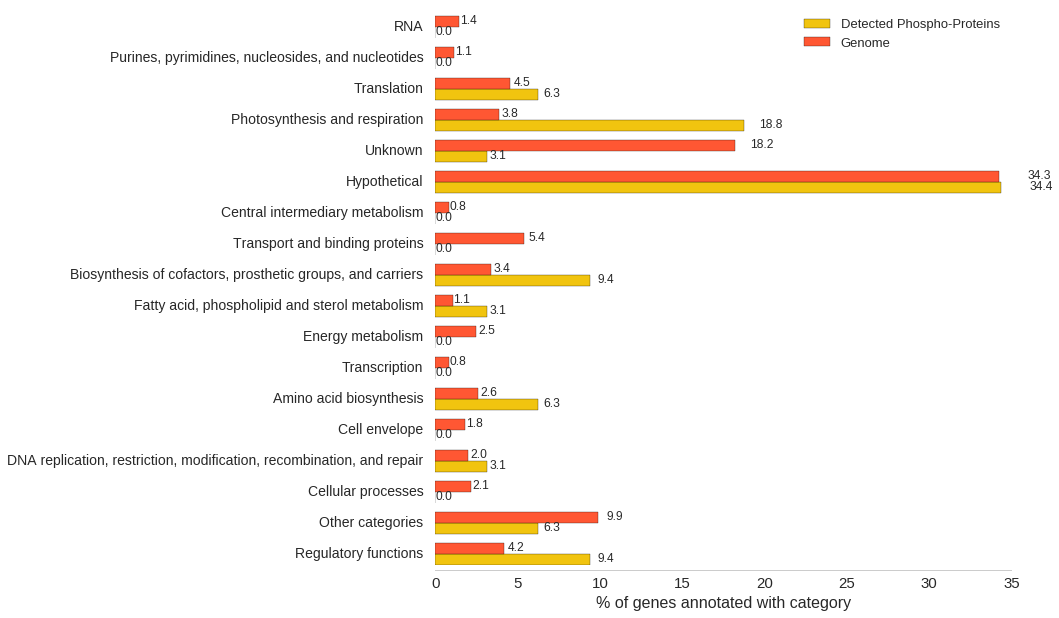

In [12]:
#Functions of the proteins that phosphopeptides belong to (Compared to total genome) . As a fraction (%) 

category_f = "/home/vitalv/database/category.txt"
category_df = pandas.read_csv(category_f, delimiter="\t", header=None)
category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]
cols = ["geneID", "definition", "first_category_name", "second_category_name"]

phospho_peptides = pandas.merge(phospho_peptides, category_df[cols], left_on='protein', right_on='geneID', how='left')

category_data_genome = category_df.groupby("first_category_name").size().to_dict()
category_data_genome_percent = {}
for cat, num in category_data_genome.items():
	category_data_genome_percent[cat] = round(float(num)/sum(category_data_genome.values()) * 100,2)

category_data_phosphoset = phospho_peptides.groupby("first_category_name").size().to_dict()
category_data_phosphoset_percent = {}
for cat, num in category_data_phosphoset.items():
	category_data_phosphoset_percent[cat] = round(float(num)/sum(category_data_phosphoset.values()) * 100,2)

_categories = [cat for cat in category_data_genome_percent.keys() if cat not in category_data_phosphoset_percent.keys()]
for c in _categories:
	category_data_phosphoset_percent[c] = 0

def autolabel(rects):
	# attach text label with bar height in barplot
	for rect in rects:
		height = rect.get_height()
		ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d'%int(height), ha='center', va='bottom', size=12)

def autolabel_width(rects):
	# attach text label with bar height in barplot
	for rect in rects:
		width = rect.get_width()
		#ax.text(1.05*width, rect.get_y()-(rect.get_height()/2.), int(width),  ha='left', va='bottom', size=12)
		ax.text(1.05*width, rect.get_y(), round(width,1),  ha='left', va='bottom', size=12)

ind = numpy.arange(len(category_data_phosphoset_percent))  
width = 0.35# the width of the bars
fig, ax = plt.subplots(1, figsize=(16,10))
categories_phospho, categories_genome = [], []
tick_labels = []
for cat, num in category_data_genome_percent.items():
	categories_phospho.append(category_data_phosphoset_percent[cat])
	categories_genome.append(category_data_genome_percent[cat])
	tick_labels.append(cat)
rects1 = ax.barh(ind, categories_phospho, width, color='#F1C40F')
rects2 = ax.barh(ind + width, categories_genome, width, color='#FF5733')
ax.set_xlabel("% of genes annotated with category", fontsize=16)
ax.set_xticklabels(range(0,40,5))
ax.set_yticks(ind + width)
ax.set_yticklabels(tick_labels)
ax.legend((rects1[0], rects2[0]), ('Detected Phospho-Proteins', 'Genome'), fontsize=13)
autolabel_width(rects1)
autolabel_width(rects2)
plt.gcf().subplots_adjust(left=0.4)
plt.grid(False) 
sb.despine(offset=5, trim=True)
sb.despine(top=True, left=True, right=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [14]:
#To get my background gene list for enrichment, get first from cons all peptides detected in at least one replicate in all 4 samples
background_genes = list(set(all_pep_prot_dict.values()))
genes = list(phospho_peptides["protein"])

def enrich(input_gene_list, background_gene_list):

	category_f = "/home/vitalv/cyano_dataset_20161118/category.txt"
	category_df = pandas.read_csv(category_f, delimiter="\t", header=None, names=["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"])
	data = category_df[category_df["geneID"].isin(input_gene_list)]
	background = category_df[category_df["geneID"].isin(background_gene_list)]
	print "first_category_annotation" + "\t" + "Genes in input list w/ annotation" + "\t" + "Genes in input list" + "\t" + "Genes in background list w/ annotation" + "\t" + "Genes in background list" + "\t" + "p-value"
	for category in data.first_category_name.unique():
		k = len(data) #input list (list of differentially abundant proteins -ANOVA<0.05-)
		x = len(data[data.first_category_name == category]) #num of genes in the input list with the annotation
		N = len(set(background_gene_list)) #background number of genes. One could use the whole genome OR better yet, the set of detected (over a certain threshold) proteins
		m = len(background[background.first_category_name == category])
		p = stats.hypergeom.sf(x, N, k, m)
		print category + "\t" + str(x) + "\t" + str(k) + "\t" + str(m) + "\t" + str(N)  + "\t" + str(p)

enrich(genes, background_genes)


first_category_annotation	Genes in input list w/ annotation	Genes in input list	Genes in background list w/ annotation	Genes in background list	p-value
Amino acid biosynthesis	2	31	67	1434	0.173316178331
Biosynthesis of cofactors, prosthetic groups, and carriers	3	31	67	1434	0.0528986503467
Fatty acid, phospholipid and sterol metabolism	1	31	24	1434	0.0929894882178
Photosynthesis and respiration	6	31	81	1434	0.00123363367231
Regulatory functions	3	31	65	1434	0.0481546638613
DNA replication, restriction, modification, recombination, and repair	1	31	31	1434	0.142888298756
Translation	2	31	126	1434	0.52209085571
Other categories	2	31	103	1434	0.38707355537
Hypothetical	10	31	431	1434	0.313015213537
Unknown	1	31	150	1434	0.852552345273


### Plot peptides abundance (grouped by protein) across samples


In [15]:
category_f = "/home/vitalv/cyano_dataset_20161118/category.txt"
category_df = pandas.read_csv(category_f, delimiter="\t", header=None, names=["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"])
peptides = pandas.merge(peptides, category_df[['geneID', 'definition']], left_on='protein', right_on='geneID', how='left')

In [16]:
def abundance_plot(peptide_set):

	title = peptide_set.protein.values[0] + "\n" + peptide_set.definition.values[0]

	for i in numpy.array(samples).reshape(num_samples, num_replica):
		avg = peptide_set[i].mean(axis=1)
		peptide_set[i[0].split("_GM_")[1].split("_")[1]+"_mean"] = avg
	means = [c for c in peptide_set.columns if "_mean" in c]

	X = range(1,num_samples+1)
	x_labels = ['60', '100', '200', '300', '1000']
	nCols = len(X)
	color_patches = []
	fig, ax = plt.subplots(figsize=(16,10))
	color=iter(plt.cm.rainbow(numpy.linspace(0,1,len(peptide_set))))
	for i, row in peptide_set.iterrows():
		sequence, p  = row.peptide, row.p_val
		Ys = row[samples].values.reshape(num_samples,num_replica).T #for scatter
		nRows = Ys.shape[0]
		#Xs=[60,100,200,300,1000]*nRows
		Xs=[1,2,3,4,5]*nRows
		c = next(color)
		ax.plot(X, row[means].values, "-", lw=3, color=c)
		ax.scatter(Xs, Ys.flatten(), color=c, s=30)
		patch = mpatches.Patch(color=c, label=sequence + " " + str(round(p,6)) )
		color_patches.append(patch)
	ax.set_ylabel("Intensity", fontsize=18)
	ax.set_ylim(ymin=0)
	ax.set_xlabel("Light (uE s-1 m2-1)", fontsize=18)
	ax.set_xticks(X)
	ax.set_xticklabels(list(x_labels))
	ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
	plt.legend(handles=color_patches, loc=0,   fontsize=16)
	plt.title(title, fontsize=20)
	ax.grid(False)
	sb.despine(offset=2, trim=True)
	sb.despine(top=True, right=True)
	plt.xticks(fontsize=16)
	plt.yticks(fontsize=16)
	plt.show()


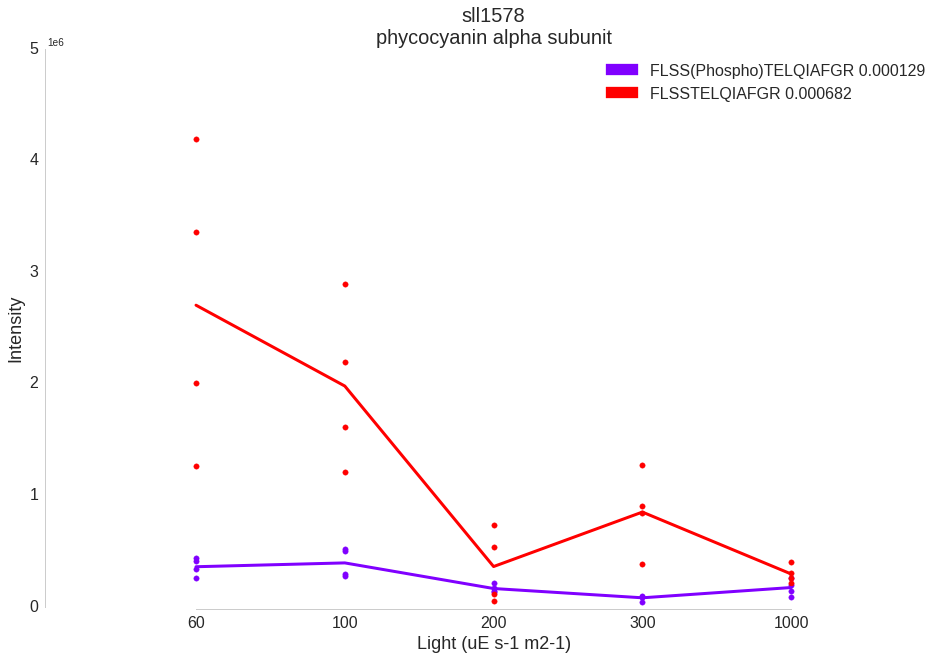

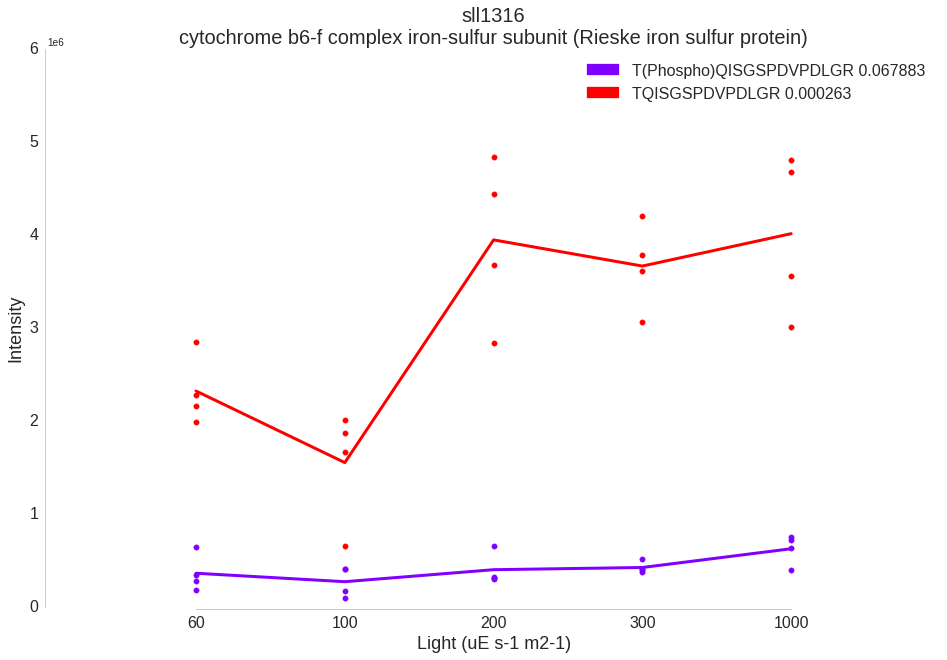

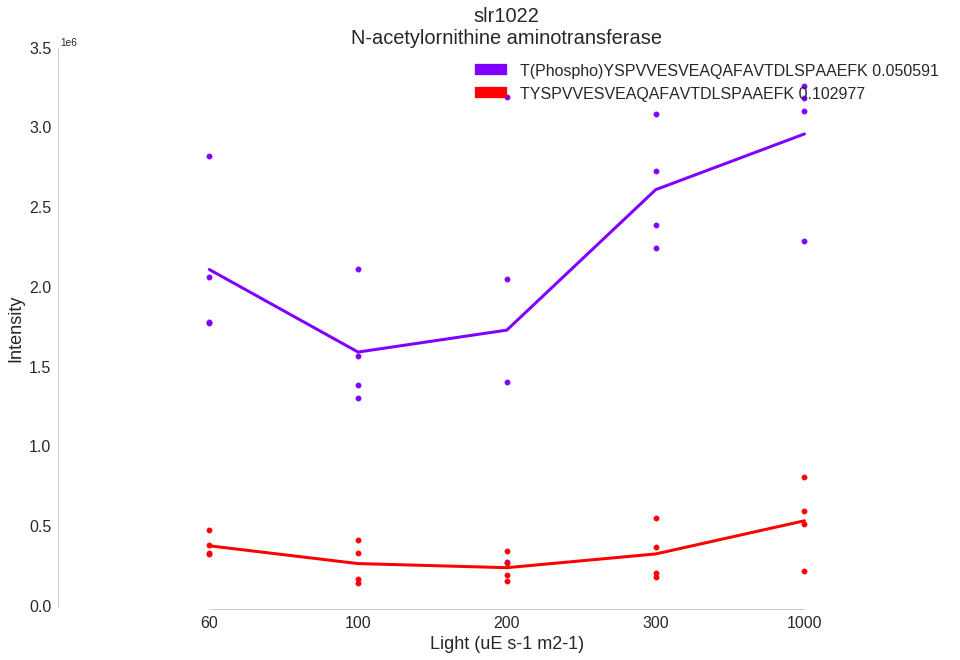

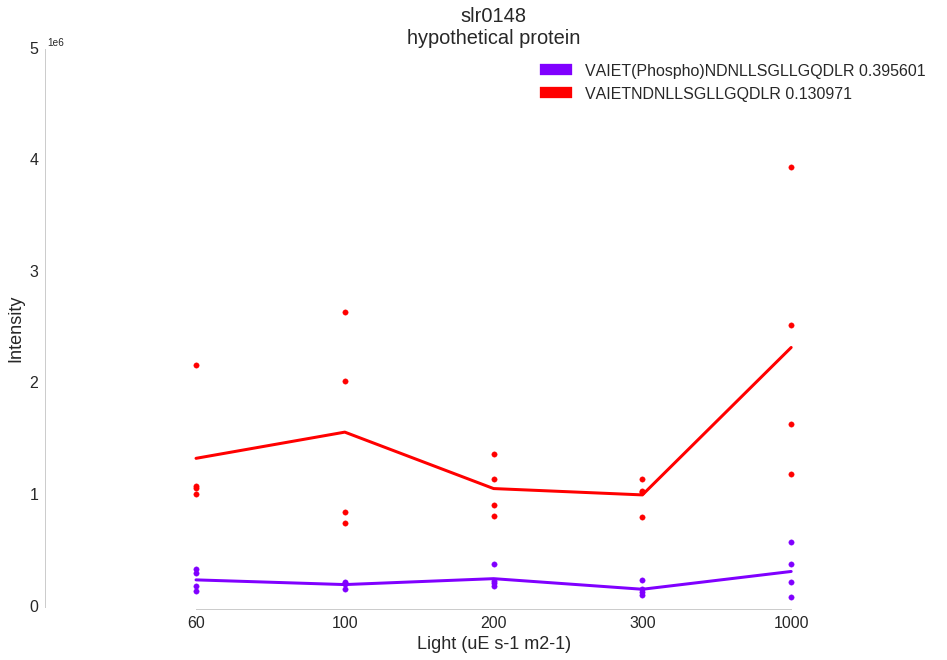

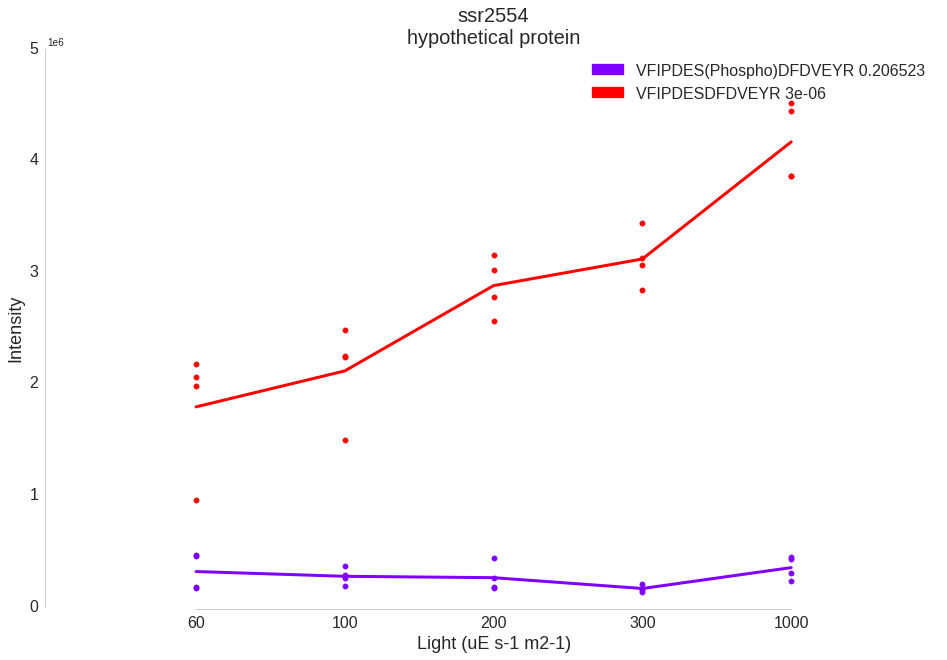

In [17]:
#Plot only those peptides where the phosphorylated and un-modified counterpart are detected

for phospho_pep in phospho_peptides.peptide: 
	un_pep = phospho_pep.replace("(Phospho)", '') #look for un-phosphorylated 
	if len(peptides[peptides.peptide == un_pep]) > 0:
		prot = peptides[peptides.peptide == phospho_pep].protein.tolist()[0]
		peptide_set = peptides[peptides.protein == prot]
		pep_unpep_pair = peptides[peptides.peptide == phospho_pep].append(peptides[peptides.peptide == un_pep])
		#abundance_plot(peptide_set)
		abundance_plot(pep_unpep_pair)


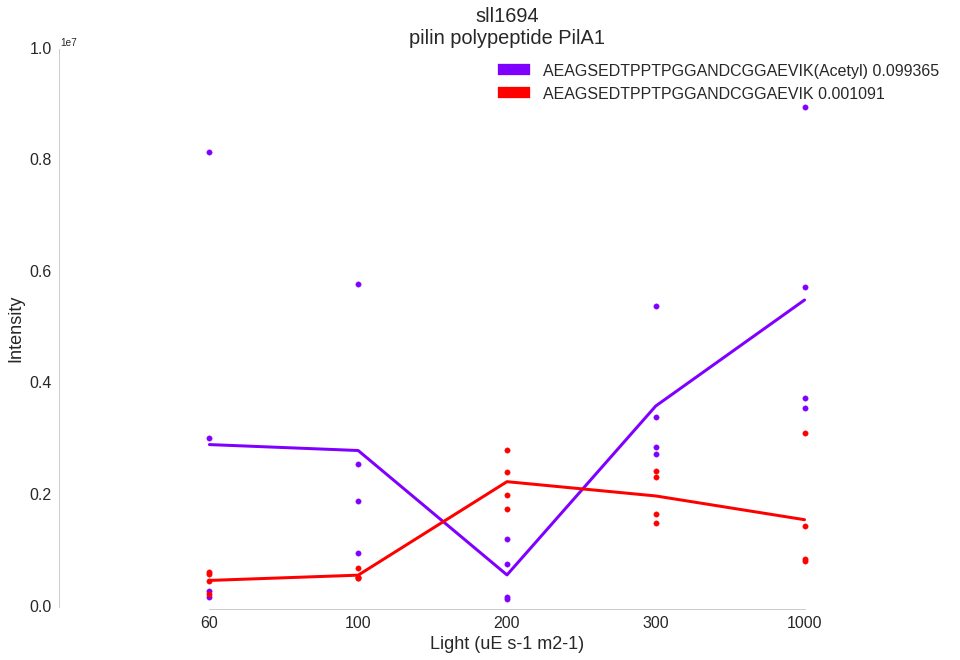

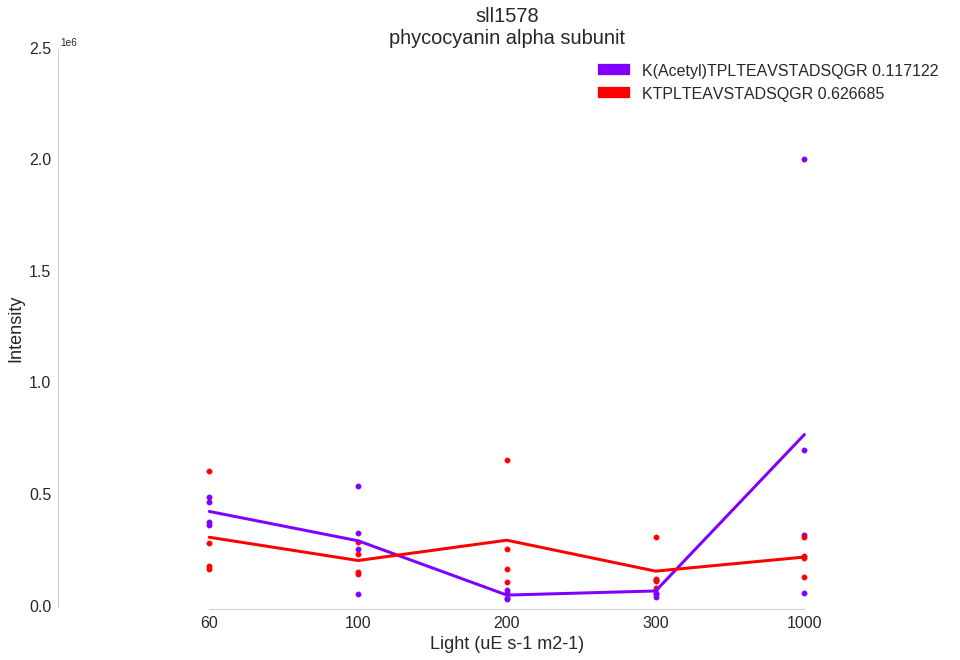

In [16]:
for pep in acetyl_peptides.peptide: 
	un_pep = pep.replace("(Acetyl)", '') #look for un-acetylated
	if len(peptides[peptides.peptide == un_pep]) > 0:
		prot = peptides[peptides.peptide == pep].protein.tolist()[0]
		peptide_set = peptides[peptides.protein == prot]
		pep_unpep_pair = peptides[peptides.peptide == pep].append(peptides[peptides.peptide == un_pep])
		#abundance_plot(peptide_set)
		abundance_plot(pep_unpep_pair)


In [17]:
#2-way ANOVA. #################################################################################################

import csv

#Factor 1 is the samples: Categories F1: 60, 100, 200, 300, 1000
#Factor 2 is the modified - unmodified: Categories F2: ptm, no_ptm
#This can only be done for proteins containing both modified and unmodified versions of the peptide


num_cat_f1,num_cat_f2,num_repl = 5,2,4
 
pep_unpep_pairs = []
for phospho_pep in phospho_peptides.peptide: 
	un_pep = phospho_pep.replace("(Phospho)", '') #look for un-phosphorylated 
	if len(peptides[peptides.peptide == un_pep]) > 0:
		prot = peptides[peptides.peptide == phospho_pep].protein.tolist()[0]
		peptide_set = peptides[peptides.protein == prot]
		pep_unpep_pair = peptides[peptides.peptide == phospho_pep].append(peptides[peptides.peptide == un_pep])
		pep_unpep_pairs.append(pep_unpep_pair)


header = ["protein"] #["60_ptm_1", "60_ptm_2", "60_ptm_3", "60_ptm_4", "60_noptm_1", "60_noptm_2", "60_noptm_3", "60_noptm_4" ...
for f1 in range(num_cat_f1):
	for f2 in range(num_cat_f2):
		for r in range(num_repl):
			header.append("f1_%s_f2_%s_R_%s"%(f1, f2, r))

#[ "f1_%s_f2_%s_R_%s"%(cat_f1, cat_f2, r) for r in range(num_repl) for cat_f2 in range(num_cat_f2) for cat_f1 in range(num_cat_f1)]


#create csv file with the required column order and then use my script 2_way_ANOVA.py (.ipynb too)
with open('pep_unpep.csv', 'wb') as csvfile:
	mywriter = csv.writer(csvfile, delimiter='\t')
	mywriter.writerow(header)
	for pep_unpep_pair in pep_unpep_pairs:
		pep = pep_unpep_pair[samples].values[0].reshape(5,4)
		unpep = pep_unpep_pair[samples].values[1].reshape(5,4)
		pep_unpep = numpy.concatenate(zip(pep, unpep)).flatten().tolist()
		protein = pep_unpep_pair.protein.tolist()[0]
		mywriter.writerow([protein] + pep_unpep)


#Now use 2_way_ANOVA.py to write p-values to pep_unpep.csv into a file named 2_way_ANOVA_PTMs.csv:
#data.to_csv("2_way_ANOVA_PTMs.csv", index=False)
#then read it
data = pandas.read_csv("/home/vitalv/cyano_dataset_20170421/PTM/2_way_ANOVA_PTMs.csv")

#Bar plot grouped. Combinations of Factor 1 and Factor 2
#datafile = "/home/vitalv/cyano_dataset_20170421/PTM/pep_unpep.csv"
#data = pandas.read_csv(datafile, delimiter="\t")



###############################################################################################################




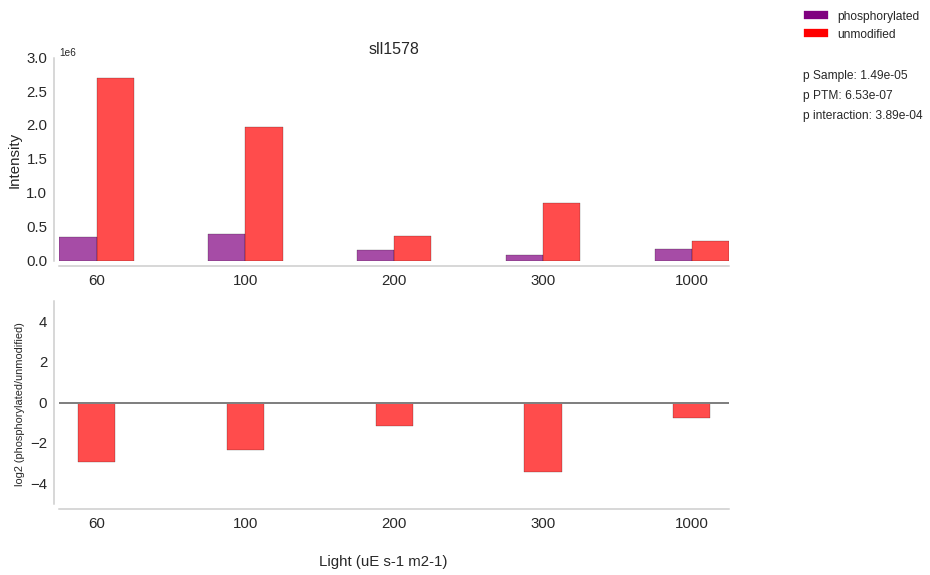

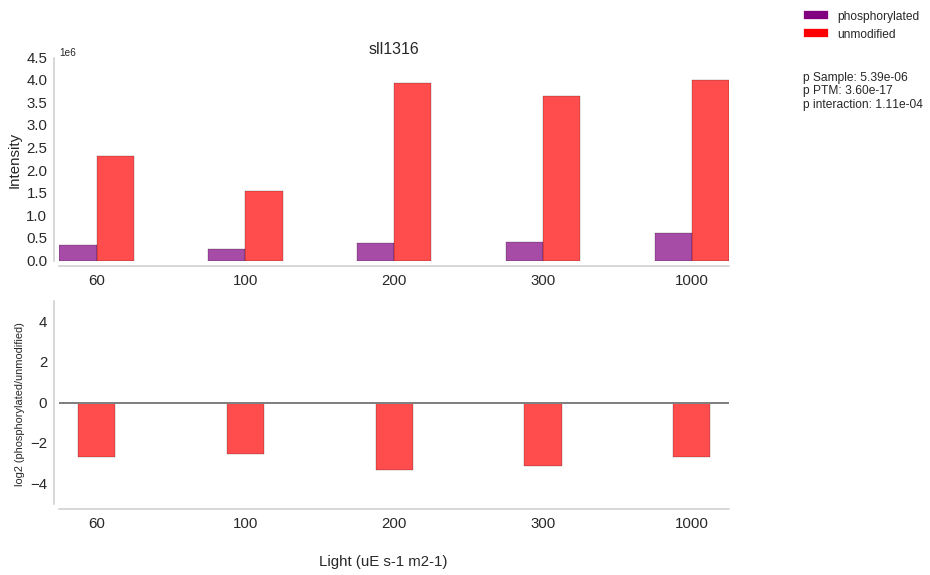

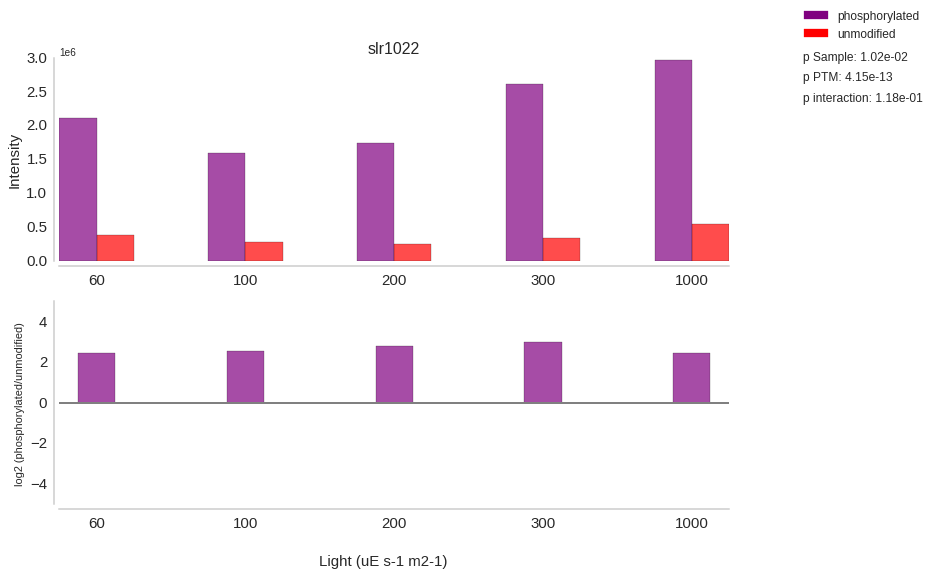

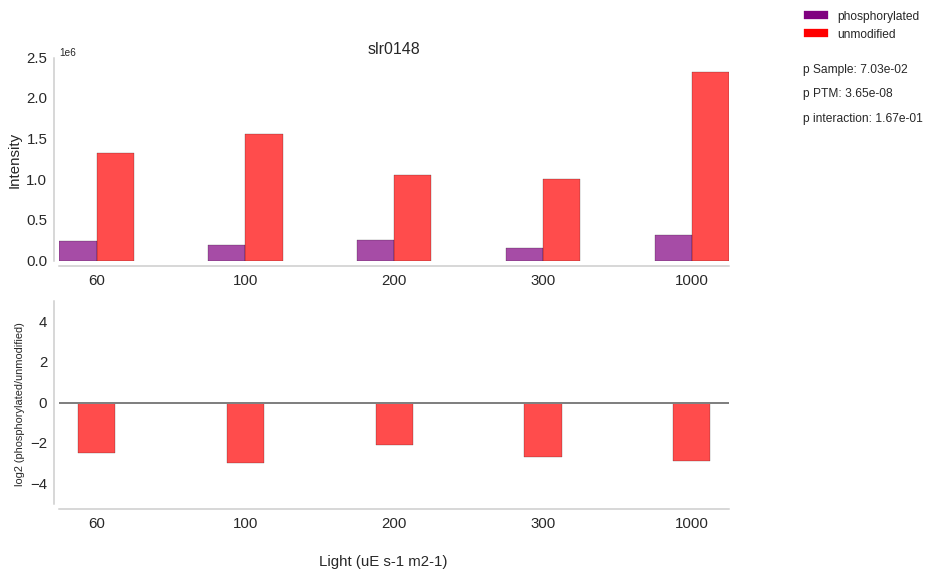

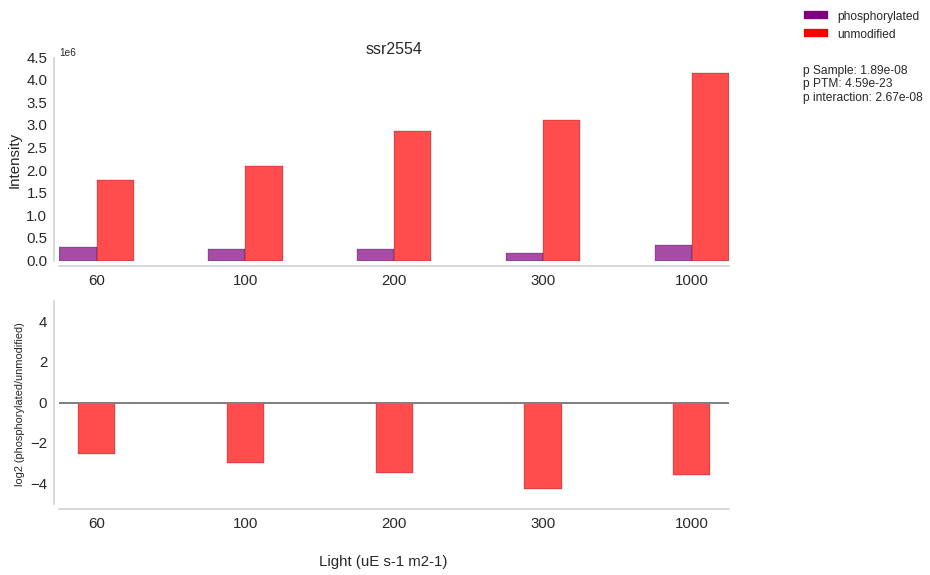

In [23]:
#Phosphoproteins in separate plots
colors = ["purple", "red"]#, "darkorange", "gray", "coal"]

for i in range(len(data)):
	f, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
	[ax.grid(False) for ax in axs]
	patches = []
	protein = data.ix[i, 'protein']
	samples = [s for s in data.columns if "f1_" in s]
	peptide_df = pandas.DataFrame(columns=["dependent_variable", "factor_1", "factor_2"])
	peptide_df.factor_1 = [ "f1_%s"%cat_f1 for cat_f1 in range(num_cat_f1) for cat_f2 in range(num_cat_f2) for rep in range(num_repl) ]
	peptide_df.factor_2 = [ "f2_%s"%cat_f2 for cat_f1 in range(num_cat_f1) for cat_f2 in range(num_cat_f2) for rep in range(num_repl) ]
	peptide_df.dependent_variable = data.iloc[i,][samples].tolist()
	width = 0.25
	colors = ["purple", "red"]#, "darkorange", "gray", "coal"]
	means_f2 = peptide_df.groupby(["factor_1", "factor_2"]).apply(lambda x: x.dependent_variable.mean())
	means_f2_df = means_f2.unstack()
	Xs = range(len(means_f2_df))
	Xs_shf = [x + width for x in Xs] #Xs top row
	Xs_mid = [x + width/2 for x in Xs] #Xs bottom row
	Ys_p = means_f2_df['f2_0'] #ptm
	Ys_u = means_f2_df['f2_1'] #un-ptm
	Ys_r = numpy.log2(means_f2_df['f2_0']/means_f2_df['f2_1']) #log2(ratios)
	axs[0].bar(Xs, Ys_p, width, alpha=0.7, color=colors[0], label="PTM" )
	axs[0].bar(Xs_shf, Ys_u, width, alpha=0.7, color=colors[1], label="Unmodified" )
	y_max = max(Ys_p.max(),Ys_u.max())
	
	axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
	axs[0].text(5, y_max, "p Sample: " + '{:.2e}'.format(data.loc[i, 'p_factor_1']))
	axs[0].text(5, y_max-3e5, "p PTM: " + '{:.2e}'.format(data.loc[i, 'p_factor_2']))
	axs[0].text(5, y_max-6e5, "p interaction: " + '{:.2e}'.format(data.loc[i, 'p_factor_1_x_factor_2']))
	#axs[1].text(1, 4.5, "phosphorylated")
	#axs[1].text(1, -4.5, "unmodified")
	[i.set_linewidth(1.5) for i in axs[0].spines.itervalues()]
	[i.set_linewidth(1.5) for i in axs[1].spines.itervalues()]


	if Ys_r[0] < 0 :
		axs[1].bar(Xs_mid, Ys_r, width, alpha=0.7, color=colors[1])
	else:
		axs[1].bar(Xs_mid, Ys_r, width, alpha=0.7, color=colors[0])

	axs[1].set_xticklabels(["60", "100", "200", "300", "1000"])
	[ax.tick_params(labelsize=15) for ax in axs]
	axs[0].set_ylabel('Intensity', fontsize=15)
	axs[1].set_ylabel('log2 (phosphorylated/unmodified)')
	axs[1].set_ylim([-5,5])
	axs[0].set_title(protein, fontsize=16)
	#note, with sharex=True I think I can only set the X for one of the axes!
	axs[0].set_xticks([x + width for x in Xs])
	#axs[1].set_xticks(Xs_mid)
	axs[1].plot([0, Xs[-1]+2*width], [0,0], '-', lw=2, color='gray')

	patches.append(mpatches.Patch(color="purple", label="Phosphorylated"))
	patches.append(mpatches.Patch(color="red", label="Unmodified"))
	f.text(0.5, 0.02, 'Light (uE s-1 m2-1)', ha='center', fontsize=15)
	plt.figlegend(handles=patches, labels=["phosphorylated", "unmodified"], fontsize=12, loc="upper right")
	plt.xlabel("", fontsize=15)
	sb.despine(offset=5)#, trim=True)
	sb.despine(top=True, right=True)

	plt.show()



In [25]:
#Plot all Phosphoproteins together

def barplots(data):

	### data is the df with columns in the required order (see header in pep_unpep.csv) ###

	f, axs = plt.subplots(2, len(data), sharey='row', sharex=True, figsize=(22, 10))
	[ax.grid(False) for ax in axs.flatten()]
	patches = []

	for i in range(len(data)):
	#pep_idx = 0
		protein = data.ix[i, 'protein']
		samples = [s for s in data.columns if "f1_" in s]
		peptide_df = pandas.DataFrame(columns=["dependent_variable", "factor_1", "factor_2"])
		peptide_df.factor_1 = [ "f1_%s"%cat_f1 for cat_f1 in range(num_cat_f1) for cat_f2 in range(num_cat_f2) for rep in range(num_repl) ]
		peptide_df.factor_2 = [ "f2_%s"%cat_f2 for cat_f1 in range(num_cat_f1) for cat_f2 in range(num_cat_f2) for rep in range(num_repl) ]
		peptide_df.dependent_variable = data.iloc[i,][samples].tolist()

		width = 0.25

		colors = ["purple", "red"]#, "darkorange", "gray", "coal"]

		means_f2 = peptide_df.groupby(["factor_1", "factor_2"]).apply(lambda x: x.dependent_variable.mean())
		means_f2_df = means_f2.unstack()
		Xs = range(len(means_f2_df))
		Xs_shf = [x + width for x in Xs]
		Xs_mid = [x + width/2 for x in Xs]

		Ys_p = means_f2_df['f2_0'] #ptm
		Ys_u = means_f2_df['f2_1'] #un-ptm
		Ys_r = numpy.log2(means_f2_df['f2_0']/means_f2_df['f2_1']) #log2(ratios)

		axs[0][i].bar(Xs, Ys_p, width, alpha=0.7, color=colors[0], label="phosphorylated" )
		axs[0][i].bar(Xs_shf, Ys_u, width, alpha=0.7, color=colors[1], label="Unmodified" )

		y_max = max(Ys_p.max(),Ys_u.max())

		axs[0][i].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

		axs[0][i].text(0, 4.3e6, "p Sample: " + '{:.2e}'.format(data.loc[i, 'p_factor_1']))
		axs[0][i].text(0, 4e6, "p PTM: " + '{:.2e}'.format(data.loc[i, 'p_factor_2']))
		axs[0][i].text(0, 3.7e6, "p interaction: " + '{:.2e}'.format(data.loc[i, 'p_factor_1_x_factor_2']))

		if Ys_r[0] < 0 :
			axs[1][i].bar(Xs_mid, Ys_r, width, alpha=0.7, color=colors[1])
		else:
			axs[1][i].bar(Xs_mid, Ys_r, width, alpha=0.7, color=colors[0])

		axs[1][i].set_xticklabels(["60", "100", "200", "300", "1000"])
		axs[0][0].set_ylabel('Intensity')
		axs[1][0].set_ylabel('log2(PTM/Unmodified)')
		axs[1][0].set_ylim([-5,5])
		axs[1][i].plot([Xs[0], Xs[-1]+1], [0,0], '-', lw=2, color="gray")
		axs[0][i].set_title(protein, fontsize=16)
		axs[0][i].set_xticks([x + width for x in Xs])
		axs[1][i].set_xticks(Xs_mid)
		#plt.xlim(min(Xs)-width, max(Xs)+width*4)
		sb.despine(offset=5)#, trim=True)
		sb.despine(top=True, right=True)

		[i.set_linewidth(1.5) for i in ax.spines.itervalues() for ax in axs[0]]
		[i.set_linewidth(1.5) for i in ax.spines.itervalues() for ax in axs[1]]
				
	patches.append(mpatches.Patch(color="purple", label="phosphorylated"))
	patches.append(mpatches.Patch(color="red", label="unmodified"))

	f.text(0.5, 0.04, 'Sample', ha='center')
	#plt.figlegend(handles=patches, labels=["PTM", "Un-PTM"], fontsize=12, loc="upper center")
	plt.figlegend(handles=patches, labels=["phosphorylated", "unmodified"], fontsize=12, loc="upper right")
	plt.xlabel("", fontsize=15)


	plt.show()

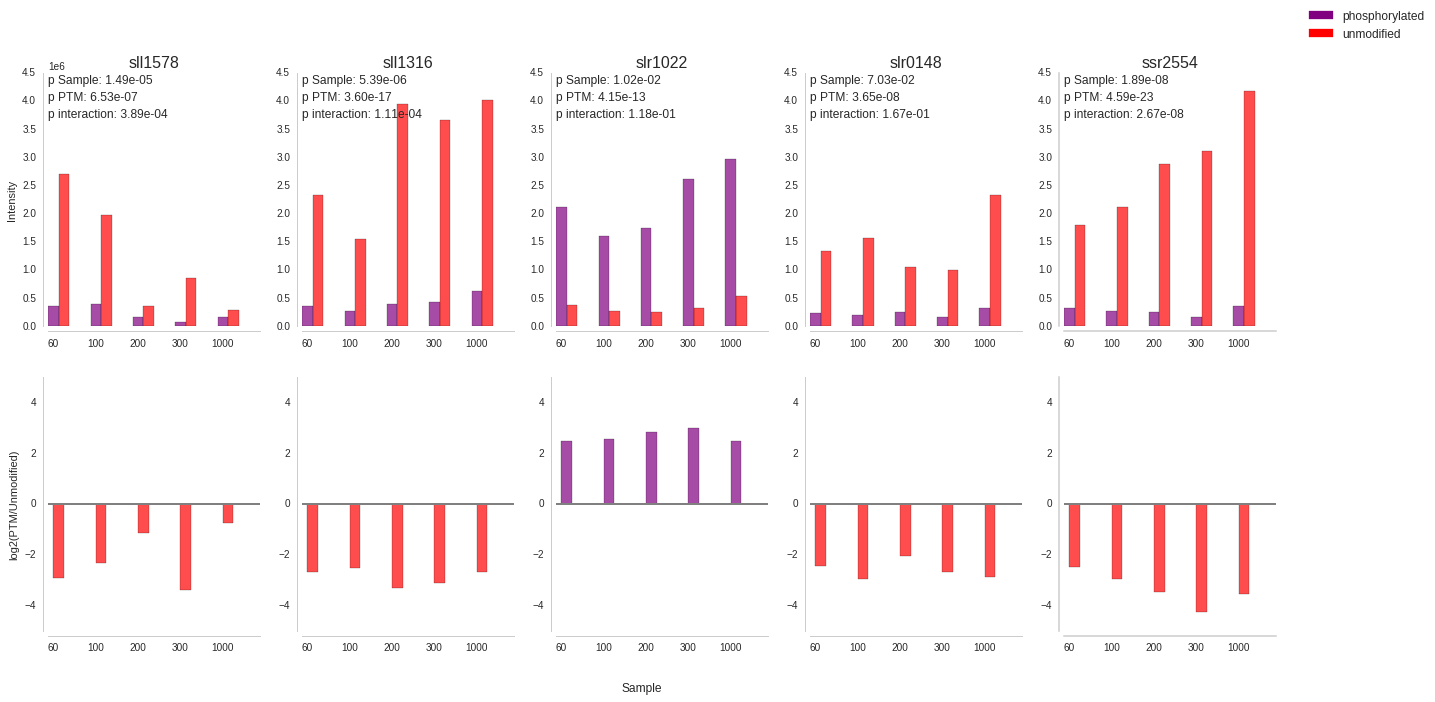

In [26]:
barplots(data)

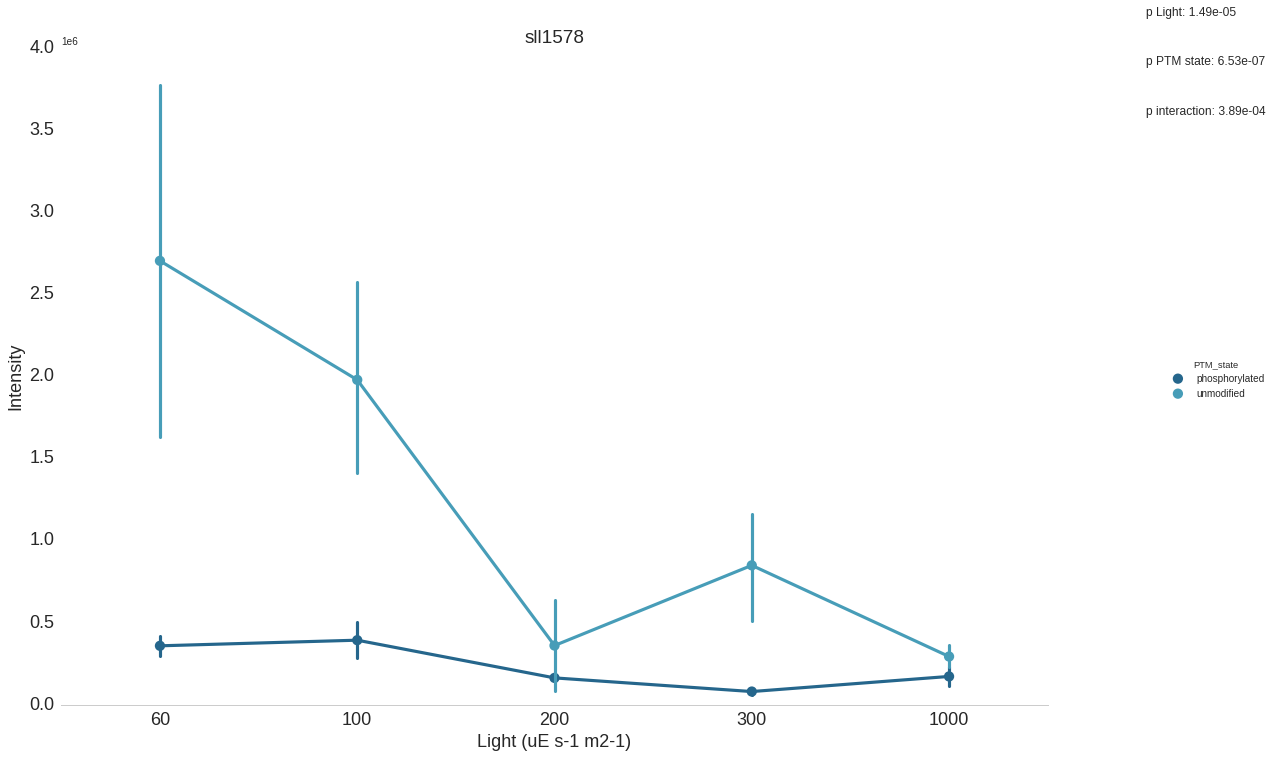

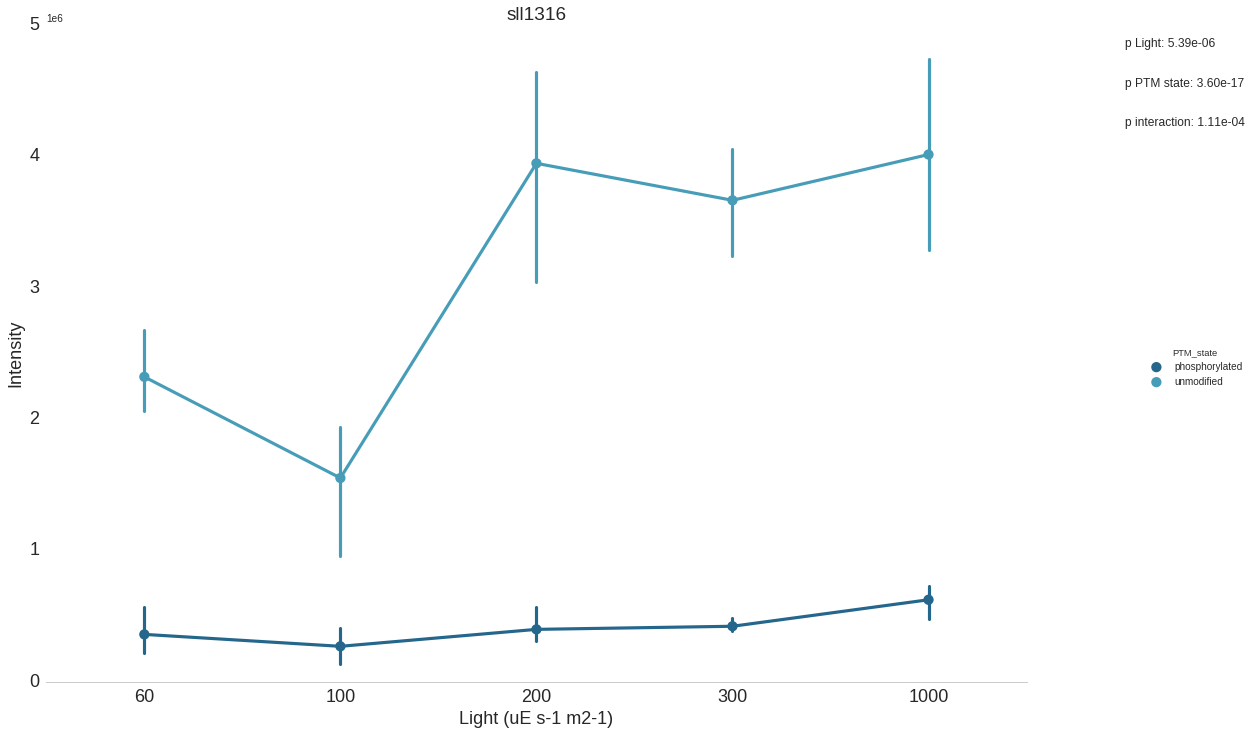

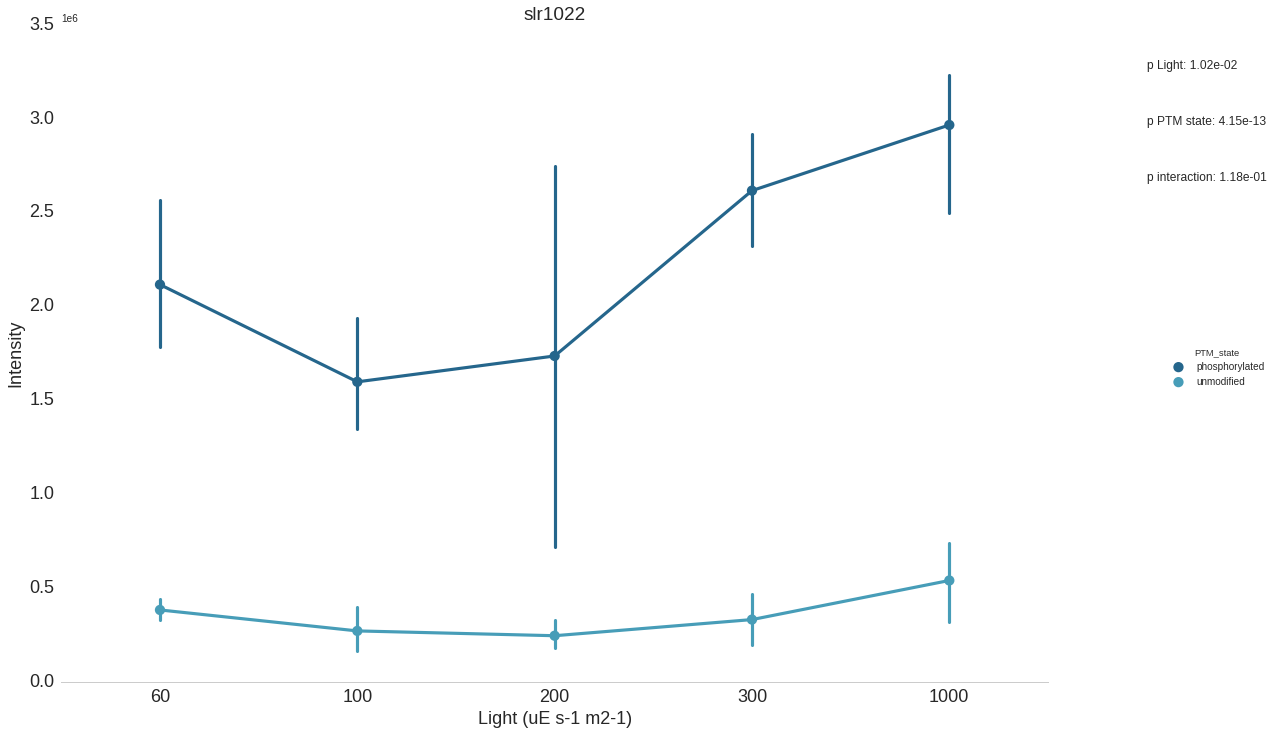

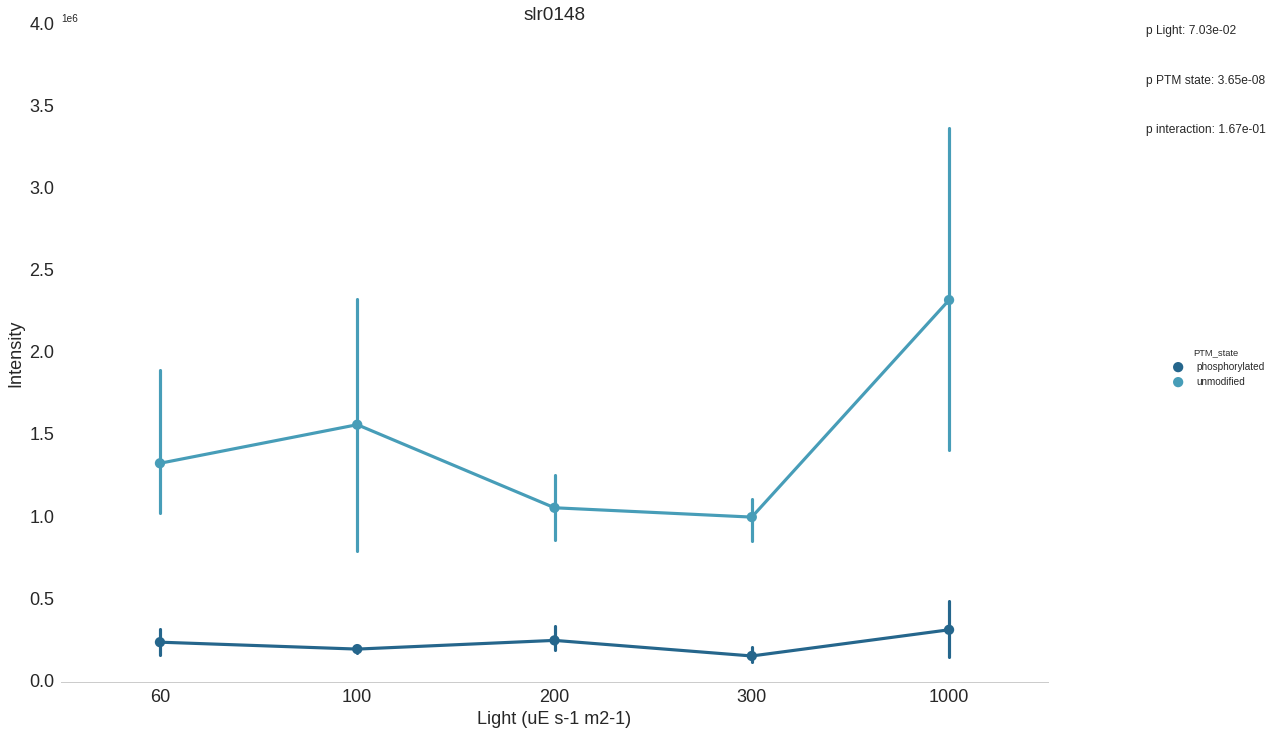

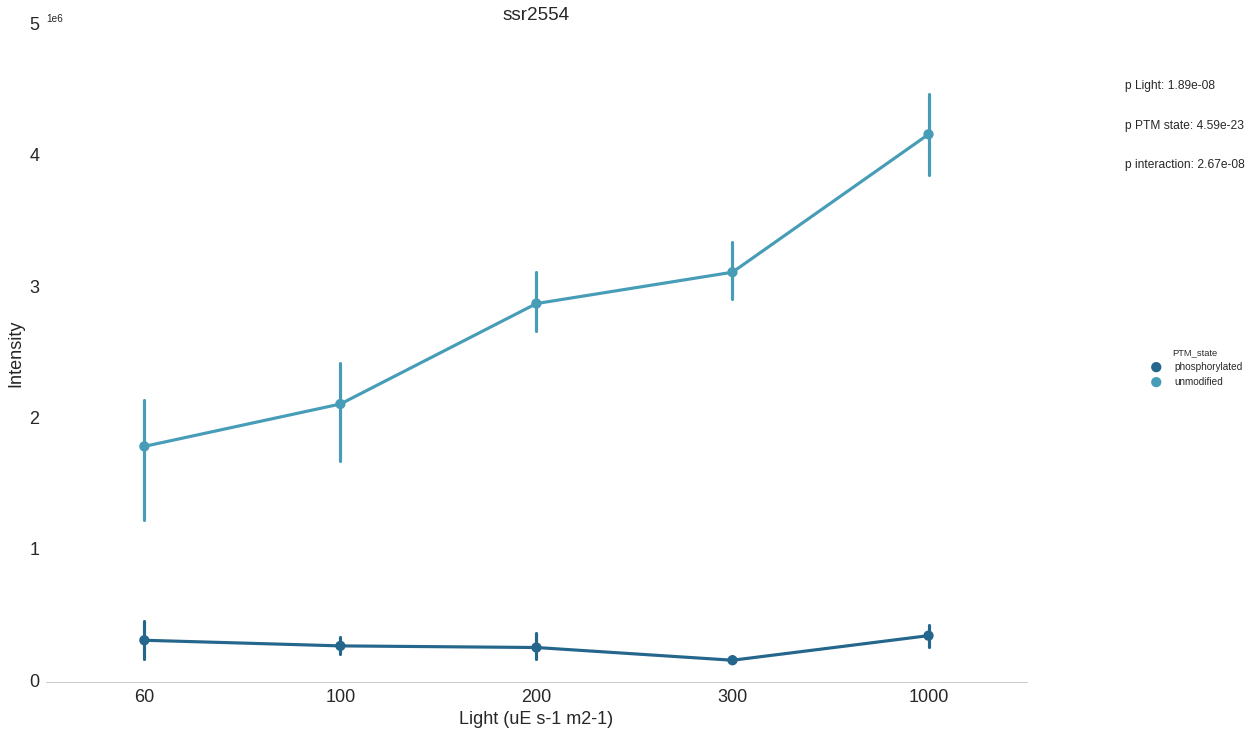

In [21]:
data = pandas.read_csv("/home/vitalv/cyano_dataset_20170421/PTM/2_way_ANOVA_PTMs.csv")

for i in range(len(data)):
	protein = data.loc[i, 'protein']
	p_light = '{:.2e}'.format(data.loc[i, 'p_factor_1']) 
	p_PTM_state = '{:.2e}'.format(data.loc[i, 'p_factor_2'])
	p_interaction = '{:.2e}'.format(data.loc[i, 'p_factor_1_x_factor_2'])
	sb_df = pandas.DataFrame()
	cols = [c for c in data.columns if c.startswith('f')]
	sb_df['Intensity'] = data.ix[i][cols]
	lights = [[i]*num_replica*2 for i in ["60", "100", "200", "300", "1000"] ] #2 is number of levels of factor 2
	lights = [val for sublist in lights for val in sublist]
	sb_df['Light'] = lights
	sb_df['PTM_state'] = (["phosphorylated"]*num_replica + ["unmodified"]*num_replica)*num_samples
	sb.factorplot(x="Light", y="Intensity", 
					hue="PTM_state",
					data=sb_df,
					palette="YlGnBu_d",
					order=["60", "100", "200", "300", "1000"],
					legend_out=True,
					size=10, aspect=1.5 )
	sb.despine(left=True)
	plt.ylim(ymin=0)
	plt.ticklabel_format(style='sci', axis='y', scilimits=(-2,2))
	plt.xticks(fontsize=18)
	plt.yticks(fontsize=18)
	plt.xlabel("Light (uE s-1 m2-1)", fontsize=18)
	plt.ylabel("Intensity", fontsize=18)
	plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
	y_max = sb_df.Intensity.max()
	plt.text(5, y_max, "p Light: " + p_light)
	plt.text(5, y_max-3e5, "p PTM state: " + p_PTM_state)
	plt.text(5, y_max-6e5, "p interaction: " + p_interaction)
	plt.title(protein, fontsize=19)
	#plt.subplots_adjust(right=.75, top=.9) #for ipython matplotlib, not needed for notebook
	plt.show()
